In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/Users/bmmorris/git/libra/')

from libra import trappist1
from libra.variability import spitzer_variability, gp_path_T1
import batman
import numpy as np

params = trappist1('b')
params.b = 0.157
params.duration = 36.19/60/24
params.u = [0.161, 0.208]
times, fluxes = np.loadtxt(gp_path_T1, unpack=True)

In [2]:
spitzer_times, spitzer_fluxes, _, _ = np.loadtxt('/Users/bmmorris/git/libra/libra/data/T1_Spitzer.txt', unpack=True, delimiter=',')

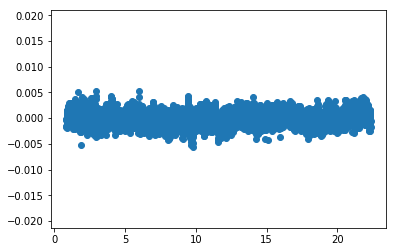

In [3]:
plt.scatter(spitzer_times, spitzer_fluxes)

In [4]:
# 1 min exposures
exp_time = np.median(np.diff(times))

times = np.arange(params.t0 - 0.02, params.t0 + 0.02, exp_time)

m = batman.TransitModel(params, times, exp_time=exp_time)
undiluted_transit = m.light_curve(params)

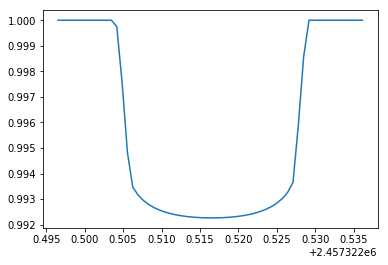

In [5]:
plt.plot(times, undiluted_transit)

In [6]:
s2_wavelength, s2_trans = np.loadtxt('/Users/bmmorris/git/libra/libra/data/filters/Spitzer_IRAC.I2.txt', unpack=True)
s2_wavelength /= 10000

spitzer_interp = lambda x: np.interp(x, s2_wavelength, s2_trans)

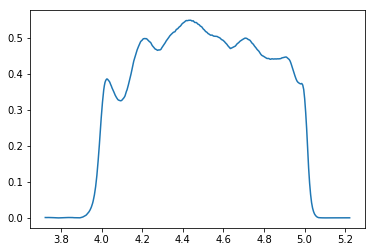

In [7]:
plt.plot(s2_wavelength, s2_trans)

In [8]:
from glob import glob

paths = glob('/Users/bmmorris/git/freckles/data/lte*BT-Settl.spec.fits')

from astropy.io import fits

wavelengths = fits.getdata(paths[0])['Wavelength']

temperatures = []
model_fluxes = []

for path in paths:
    hdu = fits.open(path)
    temperatures.append(hdu[1].header['PHXTEFF'])
    interp_flux = np.interp(wavelengths, hdu[1].data['Wavelength'], hdu[1].data['Flux'])
    model_fluxes.append(interp_flux)
    
model_fluxes = np.vstack(model_fluxes)
temperatures = np.array(temperatures)

In [9]:
teff = 2511
trappist1_flux = model_fluxes[np.argmin(np.abs(temperatures-2400)), :] * wavelengths
trappist1_spots_flux = model_fluxes[np.argmin(np.abs(temperatures-2000)), :] * wavelengths
trappist1_faculae_flux = model_fluxes[np.argmin(np.abs(temperatures-2500)), :] * wavelengths

In [10]:
f_spot = 0.35
f_fac = 0.63
eps_spitzer = 1 / (1 - f_spot * (1 - np.trapz(trappist1_spots_flux * spitzer_interp(wavelengths), wavelengths)/
                                 np.trapz(trappist1_flux * spitzer_interp(wavelengths), wavelengths)) 
              - f_fac * (1 - np.trapz(trappist1_faculae_flux * spitzer_interp(wavelengths), wavelengths)/
                         np.trapz(trappist1_flux * spitzer_interp(wavelengths), wavelengths)))
eps_spitzer

1.0331976559847718

In [160]:
f_spot = 0.004/2/np.pi
f_fac = 0.0
trappist1_spots_flux = model_fluxes[np.argmin(np.abs(temperatures-5000)), :] * wavelengths
eps_spitzer = 1 / (1 - f_spot * (1 - np.trapz(trappist1_spots_flux * spitzer_interp(wavelengths), wavelengths)/
                                 np.trapz(trappist1_flux * spitzer_interp(wavelengths), wavelengths)) 
              - f_fac * (1 - np.trapz(trappist1_faculae_flux * spitzer_interp(wavelengths), wavelengths)/
                         np.trapz(trappist1_flux * spitzer_interp(wavelengths), wavelengths)))
eps_spitzer

0.99796929755248942

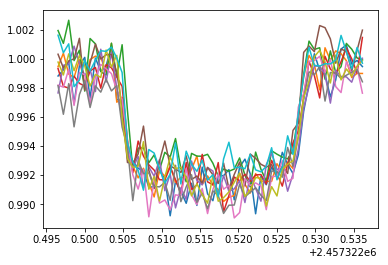

In [11]:
rackham_transit = (undiluted_transit - 1)*eps_spitzer + 1

n = len(spitzer_fluxes) - len(times)
random_starts = np.random.randint(n, size=10)

rackham_transit_noised = []

for r in random_starts:
    rackham_transit_noised.append(rackham_transit + spitzer_fluxes[r:r+len(rackham_transit)])

for r in rackham_transit_noised:
    plt.plot(times, r)

In [12]:
times_tiled = np.tile(times, len(rackham_transit_noised))
fluxes_tiled = np.concatenate(rackham_transit_noised)
yerr = np.std(fluxes_tiled[times < params.t0 - 0.015])

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 580 but corresponding boolean dimension is 58
  This is separate from the ipykernel package so we can avoid doing imports until


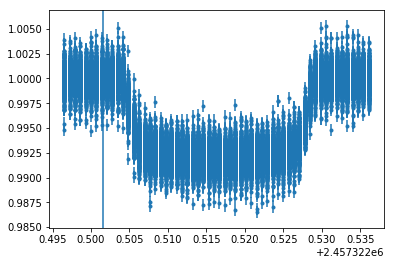

In [21]:
plt.errorbar(times_tiled, fluxes_tiled, yerr, fmt='.')
plt.axvline(params.t0 - 0.015)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:103: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2900 but corresponding boolean dimension is 58


3.7537738603368815

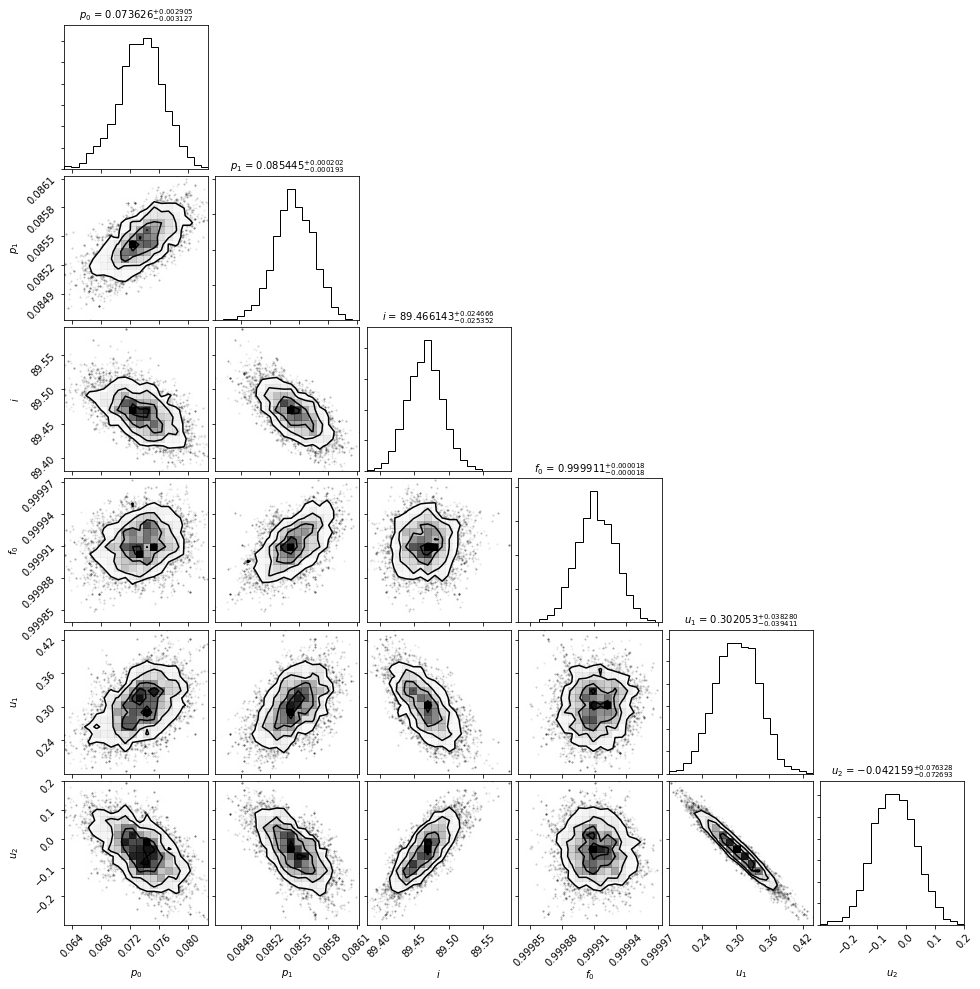

In [70]:
from copy import deepcopy
import robin #batman


def kipping_to_quadratic(p):
    q1, q2 = p
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    return u1, u2

def aRs_i(p0, T14, b, transit_params):
    """
    Convert from duration and impact param to a/Rs and inclination

    Parameters
    ----------
    transit_params : `batman.TransitParams`
        Transit parameters
    Returns
    -------
    aRs : float
        Semi-major axis in units of stellar radii
    i : float
        Orbital inclination in degrees
    """
    eccentricity = transit_params.ecc
    omega = transit_params.w
    P = transit_params.per

    # Eccentricity term for b -> a/rs conversion
    beta = (1 - eccentricity**2)/(1 + eccentricity*np.sin(np.radians(omega)))

    # Eccentricity term for duration equation:
    c = (np.sqrt(1 - eccentricity**2) /
         (1 + eccentricity*np.sin(np.radians(omega))))

    i = np.arctan(beta * np.sqrt((1 + p0)**2 - b**2) /
                  (b * np.sin(T14*np.pi / (P*c))))
    aRs = b/(np.cos(i) * beta)
    return aRs, np.degrees(i)

def transit_model(theta, x):
    r0, r1, i, f0, u1, u2 = theta
    trial_params = deepcopy(params)
    trial_params.p0 = r0
    trial_params.p1 = r1
    trial_params.u = [u1, u2]
    #, inc = aRs_i(r0, t14, b, trial_params)
    trial_params.a = 20.56
    trial_params.inc = i
    
    m = robin.TransitModel(trial_params, x, exp_time=exp_time, supersample_factor=3)
    fluxes = f0 * m.light_curve(trial_params)
    
    return fluxes
    
def lnlike(theta, x, y, yerr):
    r0, r1, i, f0, u1, u2 = theta

    model = transit_model(theta, x) 
    return -0.5*(np.sum((model - y)**2 / yerr**2))


def lnprior(theta):
    r0, r1, i, f0, u1, u2 = theta

    if 0 < r0 < 0.2 and 0.0 < r1 < 0.2 and 0 < f0 < 1.5 and 0 < i < 90 and -1 < u1 < 1 and -1 < u2 < 1:
        return 0 
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


ndim, nwalkers = 6, 12
#pos = [[params.rp, params.rp, 0] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
pos = []

q1 = (params.u[0] + params.u[1])**2
q2 = 0.5 * params.u[0] / (params.u[0] + params.u[1])

while len(pos) < nwalkers: 
    trial_pos = [params.rp, params.rp, 89.56, 1, params.u[0], params.u[1]] + 1e-2*np.random.randn(ndim)
    if np.isfinite(lnprior(trial_pos)):
        pos.append(trial_pos)

import emcee

#n_transits = [10, 20, 30, 40, 50]
n_transit = 50
random_starts = np.random.randint(n, size=n_transit)

rackham_transit_noised = []

for r in random_starts:
    rackham_transit_noised.append(rackham_transit + spitzer_fluxes[r:r+len(rackham_transit)])

times_tiled = np.tile(times, len(rackham_transit_noised))
fluxes_tiled = np.concatenate(rackham_transit_noised)
yerr = np.std(fluxes_tiled[times < params.t0 - 0.015])

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(times_tiled, fluxes_tiled, yerr),
                                threads=8)

sampler.run_mcmc(pos, 10000); 

from corner import corner

corner(sampler.chain[:, 9000:, :].reshape((-1, ndim)), #truths=[params.rp, params.rp, None, None, params.b, params.duration], 
       labels=['$p_0$', '$p_1$', '$i$', '$f_0$', '$u_1$', '$u_2$'], show_titles=True, #fig=fig, 
       title_fmt='.6f', title_kwargs=dict(fontsize=10));

p0 = sampler.chain[:, 9000:, :].reshape((-1, ndim))[:, 0]
p1 = sampler.chain[:, 9000:, :].reshape((-1, ndim))[:, 1]

abs(np.median(p0) - np.median(p1))/np.max([np.std(p0), np.std(p1)])

In [16]:
ntransits = [25, 50, 500]
nsigma = [None, 4.5, 6.3]

[0.50737525603723088,
 2.9358650940399555,
 2.0480981590214449,
 5.3157931976854185]

In [ ]:
# init_f = transit_model([params.rp*1, params.rp*1, 89.56, 1, params.u[0], params.u[1]], times)

# #plt.errorbar(times, fluxes, yerr, fmt='.', color='k', ecolor='gray')
# plt.scatter(times_tiled, fluxes_tiled, marker=',')
# plt.plot(times, init_f, 'r', zorder=10)

In [146]:
from glob import glob
import numpy as np
paths = glob('sig_???.txt')

sigs = np.array([float(np.loadtxt(p)) for p in paths])
sigs, np.median(sigs)

(array([ 0.51728689,  2.02376345,  1.12491287,  0.33112309,  1.55089769,
         2.61943984,  2.18978246,  2.22031148,  0.04364882,  1.29225039]),
 1.4215740435020656)

In [147]:
# 100 transits of trappist-1b: 
from glob import glob
import numpy as np
paths = glob('sig_2_???.txt')

sigs = np.array([float(np.loadtxt(p)) for p in paths])
sigs, np.median(sigs)

(array([ 2.7476561 ,  2.07896554,  3.32004788,  3.62808108,  5.44186293,
         2.33327102,  4.37402301,  2.54268048,  3.08364994,  3.11528009]),
 3.0994650153946512)

In [159]:
# 10 transits of trappist-1g: 
from glob import glob
import numpy as np
paths = glob('sig_g_???.txt')

sigs = np.array([float(np.loadtxt(p)) for p in paths])
sigs, np.median(sigs)

(array([  3.73351547,   9.83010087,   4.47987223,   6.12955467,
          2.97964056,   3.65155142,   4.38276994,  10.57646413]),
 4.4313210810903048)